In [1]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.table import Table, hstack, vstack
from scipy.stats import ks_2samp, beta
from functools import reduce

import math
import mpl_style
import csv
import hex_scatter as hs

H0 = 70.
cosmo = FlatLambdaCDM(H0, Om0=0.3)
h = H0/100

In [2]:
galaxy_table = Table(fits.getdata('galaxy_table_update.fits'))
group_table = Table(fits.getdata('group_table_update.fits'))

In [3]:
#this cell creates fraction of galaxy type plots, split by central and satellite

def plot_fraction(inds, labels, cent_xlim, sat_xlim, mass, mass_type='halo'):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax = [ax1,ax2]
    f.set_figheight(6)
    f.set_figwidth(15)
    
    
    colors = ['b', 'g', 'r']
    markers = ['*', '^', 'o']
    c = 0.95
    mass = np.array(mass)
    
    centorsat = [cent_ind, sat_ind]
    xlims = [cent_xlim, sat_xlim]
    
    all_norm_hists = []
    all_hists_yerr = []
    for i in range(2): #loop through to create histograms and errors for centrals and satellites
        mass_arrs = []
        for j in range(3): #now loop through to create histograms for each (i.e. spiral, int, smooth)
            ind = np.intersect1d(inds[j], centorsat[i])
            if mass_type == 'halo':
                ind = np.intersect1d(ind, halo_mass_val_ind_gal) #only include galaxies with real measured halo masses
            mass_arrs.append(mass[ind])
    
        all_mass = np.concatenate((mass_arrs[0], mass_arrs[1], mass_arrs[2])) 
        
        all_mass = np.sort(all_mass) #this is for binning by percentile, must remove zero nonphysical halo masses
        i = 0
        n = 0
        while i <= 0:
            i = all_mass[n]
            n += 1
        nonzero_all_mass = all_mass[n-1:]

        bin_edges = np.percentile(nonzero_all_mass, np.linspace(0, 100, 5)) #these bins have an equal number of galaxies in each
        plotpts = [] #plotpts is the midpoint of each histogram bin
        for i in range(len(bin_edges[:-1])):
            plotpts.append(bin_edges[i] + (bin_edges[i+1]-bin_edges[i])/2)

        hists = []
        for j in range(3): #loop thru again to create histograms
            hist, bins = np.histogram(mass_arrs[j], bin_edges)
            hists.append(hist)
        all_hist = hists[0] + hists[1] + hists[2]
        print(all_hist)
        norm_hist_type = []
        hist_yerr_type = []
        for j in range(3): #loop through yet again to normalize histograms and make errors
            norm_hist = hists[j]/all_hist
            p_lower = beta.ppf((1-c)/2.,hists[j]+1,all_hist-hists[j]+1)
            p_upper = beta.ppf(1-(1-c)/2.,hists[j]+1,all_hist-hists[j]+1)
            yerr = np.array((norm_hist - p_lower, p_upper - norm_hist))
            hist_yerr_type.append(yerr)
            norm_hist_type.append(norm_hist)
            
        all_norm_hists.append(norm_hist_type)
        all_hists_yerr.append(hist_yerr_type)
    for c in range(2):
        for j in range(len(all_norm_hists[c])):
            ax[c].errorbar(plotpts, all_norm_hists[c][j], all_hists_yerr[c][j], c=colors[j], marker=markers[j], label=labels[j])
        if mass_type == 'halo':
            ax[c].set_xlabel(r'$\log (M_{halo}/M_{\odot}/h)$')
        elif mass_type == 'gal':
            ax[c].set_xlabel(r'$\log (M_{gal}/M_{\odot})$')
        ax[c].set_xlim(xlims[c])
    ax2.legend()
    f.subplots_adjust(wspace=0)
    f.text(0.135, 0.83,'a) centrals',fontsize=20)
    f.text(0.53, 0.83,'b) satellites',fontsize=20)
    return f

In [4]:
#cell initializing different indices for use later
#group_table indices
pair_ind = np.where(group_table['n_gal'] == 2)[0]
group_ind = np.where(group_table['n_gal'] > 2)[0]

halo_mass_val_ind = np.where(group_table['halo_mass_lum'] > 2)[0]
cent_mass_val_ind = np.where(group_table['cent_mstell'] > 0)[0]


high_sat_sf_ind = np.where(group_table['sat_sf_frac'] > 0.5)
low_sat_sf_ind = np.where(group_table['sat_sf_frac'] < 0.5)

spiral_sat_ind = np.where(group_table['sat_spiral_frac'] > 0.5)[0]
smooth_sat_ind = np.where(group_table['sat_smooth_frac'] > 0.5)[0]
int_sat_ind = np.intersect1d(np.where(group_table['sat_spiral_frac'] <= 0.5)[0], np.where(group_table['sat_smooth_frac'] <= 0.5)[0])

spiral_half_sat_ind = np.where(group_table['sat_spiral_half_frac'] > 0.5)[0]
smooth_half_sat_ind = np.where(group_table['sat_spiral_half_frac'] < 0.5)[0]

high_mass_halo_ind = np.where(group_table['halo_mass_lum'] >= 13 - np.log10(h))[0]
low_mass_halo_ind = np.where(group_table['halo_mass_lum'] < 13 - np.log10(h))[0]
low_mass_halo_ind = np.intersect1d(low_mass_halo_ind, np.where(group_table['halo_mass_lum'] > 2)[0])

high_mass_cent_ind = np.where(group_table['cent_mstell'] >= 10.5)[0]
low_mass_cent_ind = np.where(group_table['cent_mstell'] < 10.5)[0]

sf_cent_ind = np.where(group_table['sfing_central'] == 'SFing')[0]
passive_cent_ind = np.where(group_table['sfing_central'] == 'passive')[0]

red_cent_ind = np.where(group_table['cent_redblue'] == 'red')[0]
blue_cent_ind = np.where(group_table['cent_redblue'] == 'blue')[0]

spiral_cent_ind = np.where(group_table['cent_pfeat'] >= 0.8)[0]
smooth_cent_ind = np.where(group_table['cent_pfeat'] <= 0.2)[0]
int_cent_ind = np.intersect1d(np.where(group_table['cent_pfeat'] < 0.8)[0],np.where(group_table['cent_pfeat'] > 0.2)[0])
    
spiral_half_cent_ind = np.where(group_table['cent_pfeat'] >= 0.5)[0]
smooth_half_cent_ind = np.where(group_table['cent_pfeat'] < 0.5)[0]
    
#central morphology/color of groups
redelliptical_cent_ind = np.intersect1d(red_cent_ind, smooth_cent_ind) 
blueelliptical_cent_ind = np.intersect1d(blue_cent_ind, smooth_cent_ind)
redspiral_cent_ind = np.intersect1d(red_cent_ind, spiral_cent_ind)
bluespiral_cent_ind = np.intersect1d(blue_cent_ind, spiral_cent_ind)

#galaxy_table indices
cent_ind = np.where(galaxy_table['centsat'] == 1)[0]
sat_ind = np.where(galaxy_table['centsat'] == 2)[0]

mass_val_ind_gal = np.where(galaxy_table['mstell'] > 0)[0] #remove galaxies without measured mass
halo_mass_val_ind_gal = np.where(galaxy_table['halo_mass_lum'] > 2)[0]

pair_ind_gal = np.where(galaxy_table['n_gal'] == 2)[0]
group_ind_gal = np.where(galaxy_table['n_gal'] > 2)[0]

spiralgal_ind_gal = np.where(galaxy_table['pfeatures'] >= 0.8)[0] #these are the properties of each galaxy
intgal_ind_gal = np.intersect1d(np.where(galaxy_table['pfeatures'] < 0.8)[0],np.where(galaxy_table['pfeatures'] > 0.2)[0])
smoothgal_ind_gal = np.where(galaxy_table['pfeatures'] <= 0.2)[0]

passivegal_ind_gal = np.where(galaxy_table['passiveorSFing'] == 'passive')[0]
SFinggal_ind_gal = np.where(galaxy_table['passiveorSFing'] == 'SFing')[0]

passivesat_ind_gal = np.where(galaxy_table['sat_sf_frac'] < 0.5)[0]
SFingsat_ind_gal = np.where(galaxy_table['sat_sf_frac'] > 0.5)[0]

smoothsat_ind_gal = np.where(galaxy_table['sat_smooth_frac'] > 0.5)[0]
spiralsat_ind_gal = np.where(galaxy_table['sat_spiral_frac'] > 0.5)[0]
intsat_ind_gal = np.intersect1d(np.where(galaxy_table['sat_spiral_frac'] <= 0.5)[0], np.where(galaxy_table['sat_smooth_frac'] <= 0.5)[0])


spiral_cent_ind_gal = np.where(galaxy_table['cent_pfeat'] >= 0.8)[0] #these are central properties
smooth_cent_ind_gal = np.where(galaxy_table['cent_pfeat'] <= 0.2)[0]

redgal_ind_gal = np.where(galaxy_table['redorblue'] == 'red')[0]
bluegal_ind_gal = np.where(galaxy_table['redorblue'] == 'blue')[0]

#galaxies with SF and color properties
redactive_gal_ind_gal = np.intersect1d(SFinggal_ind_gal, redgal_ind_gal)
blueactive_gal_ind_gal = np.intersect1d(SFinggal_ind_gal, bluegal_ind_gal)
redpassive_gal_ind_gal = np.intersect1d(passivegal_ind_gal, redgal_ind_gal)
bluepassive_gal_ind_gal = np.intersect1d(passivegal_ind_gal, bluegal_ind_gal)

red_cent_ind_gal = np.where(galaxy_table['cent_redblue'] == 'red')[0]
blue_cent_ind_gal = np.where(galaxy_table['cent_redblue'] == 'blue')[0]
                             
#central morphology/color
redelliptical_cent_ind_gal = np.intersect1d(red_cent_ind_gal, smooth_cent_ind_gal) 
blueelliptical_cent_ind_gal = np.intersect1d(blue_cent_ind_gal, smooth_cent_ind_gal)
redspiral_cent_ind_gal = np.intersect1d(red_cent_ind_gal, spiral_cent_ind_gal)
bluespiral_cent_ind_gal = np.intersect1d(blue_cent_ind_gal, spiral_cent_ind_gal)

#all galaxies morphology/color
redelliptical_ind_gal = np.intersect1d(redgal_ind_gal, smoothgal_ind_gal)
blueelliptical_ind_gal = np.intersect1d(bluegal_ind_gal, smoothgal_ind_gal)
redspiral_ind_gal = np.intersect1d(redgal_ind_gal, spiralgal_ind_gal)
bluespiral_ind_gal = np.intersect1d(bluegal_ind_gal, spiralgal_ind_gal)

sf_cent_ind_gal = np.where(galaxy_table['sfing_central'] == 'SFing')[0]
passive_cent_ind_gal = np.where(galaxy_table['sfing_central'] == 'passive')[0]

high_mass_halo_ind_gal = np.where(galaxy_table['halo_mass_lum'] >= 13 - np.log10(h))[0]
low_mass_halo_ind_gal = np.where(galaxy_table['halo_mass_lum'] < 13 - np.log10(h))[0]

high_mass_cent_ind_gal = np.where(galaxy_table['cent_mass'] >= 10.5)[0]
low_mass_cent_ind_gal = np.where(galaxy_table['cent_mass'] < 10.5)[0]

[685 685 685 686]
[1951 1946 1951 1954]


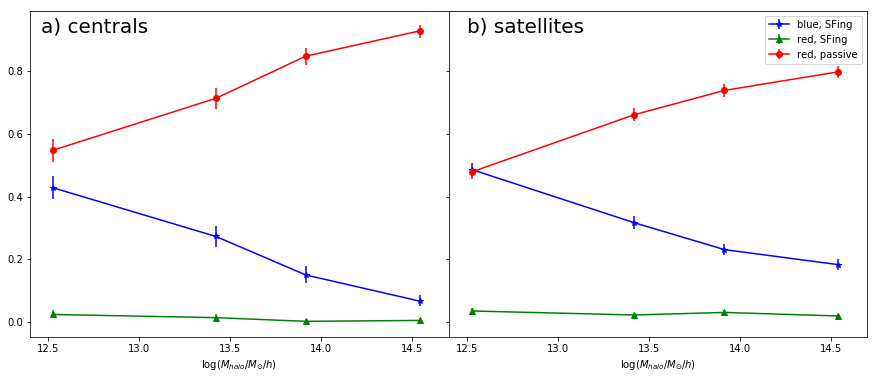

In [23]:
inds = [blueactive_gal_ind_gal, redactive_gal_ind_gal, redpassive_gal_ind_gal]
labels = ['blue, SFing', 'red, SFing', 'red, passive']
cent_xlim = (12.4, 14.7)
sat_xlim = (12.4, 14.7)
plot_fraction(inds, labels, cent_xlim, sat_xlim, galaxy_table['halo_mass_lum'], 'halo')
plt.style.use(mpl_style.style1)
#plt.savefig('plots/frac_SFcolor_halomass', dpi=400)
plt.show()

[817 817 817 818]
[2242 2235 2241 2249]


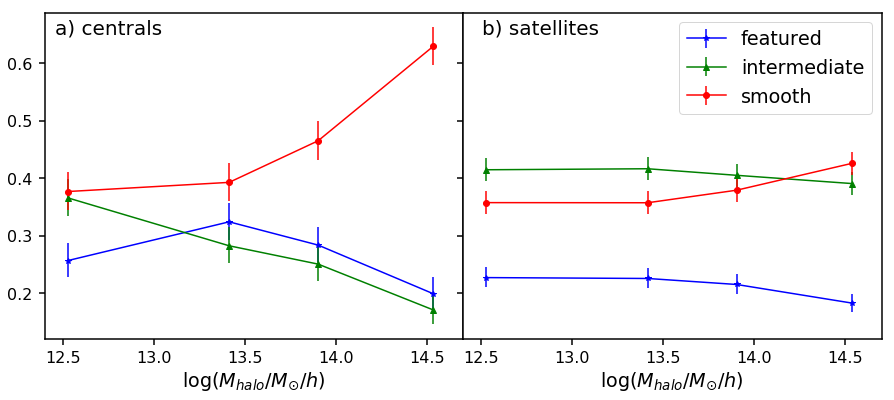

In [24]:
inds = [spiralgal_ind_gal, intgal_ind_gal, smoothgal_ind_gal]
labels = ['featured', 'intermediate', 'smooth']
cent_xlim = (12.4, 14.7)
sat_xlim = (12.4, 14.7)
plot_fraction(inds, labels, cent_xlim, sat_xlim, galaxy_table['halo_mass_lum'], 'halo')
plt.style.use(mpl_style.style1)
#plt.savefig('plots/frac_morph_halomass', dpi=400)
plt.show()

[687 686 687 687]
[1951 1950 1951 1951]


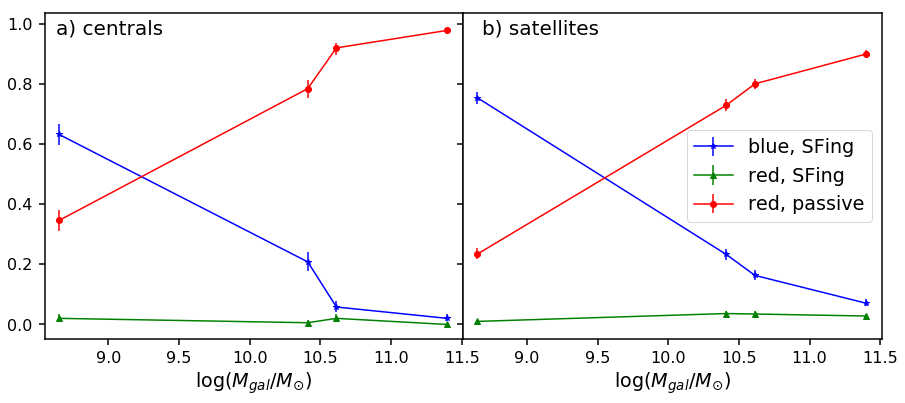

In [26]:
#fraction of galaxy type by galaxy mass
inds = [blueactive_gal_ind_gal, redactive_gal_ind_gal, redpassive_gal_ind_gal]
labels = ['blue, SFing', 'red, SFing', 'red, passive']
cent_xlim = (8.55, 11.51)
sat_xlim = (8.55, 11.51)
plot_fraction(inds, labels, cent_xlim, sat_xlim, galaxy_table['mstell'], 'gal')
plt.style.use(mpl_style.style1)
#plt.savefig('plots/frac_SFcolor_galmass', dpi=400)
plt.show()

[817 817 817 818]
[2235 2234 2235 2235]


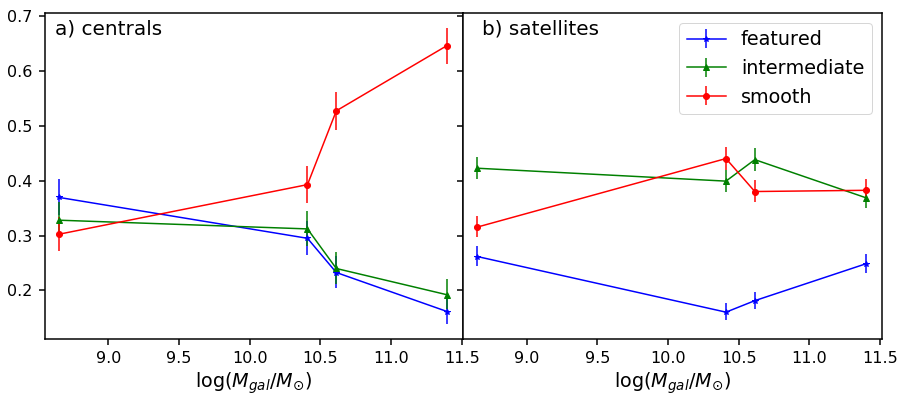

In [27]:
inds = [spiralgal_ind_gal, intgal_ind_gal, smoothgal_ind_gal]
labels = ['featured', 'intermediate', 'smooth']
cent_xlim = (8.55, 11.51)
sat_xlim = (8.55, 11.51)
plot_fraction(inds, labels, cent_xlim, sat_xlim, galaxy_table['mstell'], 'gal')
plt.style.use(mpl_style.style1)
#plt.savefig('plots/frac_morph_galmass', dpi=400)
plt.show()

In [5]:
#this creates a 4 panel plot. The left and right sides are split (e.g. pairs and groups)
#in each plot there are two different histograms ploted (and the total)

def plot_dist_pts(L_arrs, R_arrs, L_cross, R_cross, L_mass_arrs, R_mass_arrs, all_mass, xlabel, left_label, right_label, plot_labels, bin_type='good', axloc='best', dev_type ='normal'):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
    ax_side = [[ax1, ax3],[ax2, ax4]]
    f.set_figheight(10)
    f.set_figwidth(15)

    hists = []
    plotpts = []

    colors = ['b', 'r']
    markers = ['*', 'o']
    labels = ['', '']
    all_arrs = [L_arrs, R_arrs]

    total_mass_R = np.concatenate(R_mass_arrs)
    total_mass_L = np.concatenate(L_mass_arrs)
    total_mass_arrs = [total_mass_L, total_mass_R]

    side_mass_arrs = [L_mass_arrs, R_mass_arrs]
    cross = [L_cross, R_cross]

    mbins = np.arange(np.min(all_mass), np.max(all_mass), 1)

    for i in range(2): #looping for left and right side
        ax = ax_side[i]

        if i == 0:
            use_label = ['','','']
        else:
            use_label = [plot_labels[0], plot_labels[1], 'all']

        arrays = all_arrs[i]
        total = np.concatenate(arrays) #should include all arrays not just 0 and 1

        total_side_coeffs = mass_match(total_mass_arrs[i], all_mass, mbins)

        whichmassbin = np.digitize(total_mass_arrs[i], mbins[:-1]) #this gives which # mass bin each entry is in
        whichmassbin = whichmassbin -1
        weights_all = np.array(whichmassbin, dtype='float')
        for b in range(len(mbins[:-1])):
            ind = np.where(whichmassbin == b)[0]
            weights_all[ind] = total_side_coeffs[b] #changes bin number to the actual weight coefficient

        if bin_type == 'good':
            total_lower = total[total < cross[i]]
            total_upper = total[total >= cross[i]]
            bin_edges_lower = np.percentile(total_lower, np.array((0,50,100)))
            bin_edges_upper = np.percentile(total_upper, np.array((50,100)))
            bin_edges = np.concatenate((bin_edges_lower, bin_edges_upper))
        if bin_type == 'linear':
            bin_edges = np.percentile(total, np.linspace(0,100,10))

        plotpts = []
        for b in range(len(bin_edges[:-1])): #creating points to plot - midpoints of bins
            plotpts.append(bin_edges[b] + (bin_edges[b+1]-bin_edges[b])/2)

        total_hist, bins = np.histogram(total, weights=weights_all, density=True, bins=bin_edges) #total histogram, bins is throwaway
        ax[0].plot(plotpts, total_hist, c='k', marker='^', linestyle='--', label=use_label[2])

        for j in range(2): #looping for two arrays within one side
            side_coeffs = mass_match(side_mass_arrs[i][j], all_mass, mbins)
            whichmassbin = np.digitize(side_mass_arrs[i][j], mbins[:-1]) #this gives which # mass bin each entry is in
            whichmassbin = whichmassbin - 1
            weight_arr = np.array(whichmassbin, dtype='float')
            for b in range(len(mbins[:-1])):
                ind = np.where(whichmassbin == b)[0]
                weight_arr[ind] = side_coeffs[b] #changes bin number to the actual weight coefficient

            norm_hist, bins = np.histogram(arrays[j], weights=weight_arr, density=True, bins=bin_edges)
            unnorm_hist, bins = np.histogram(arrays[j], weights=weight_arr, density=False, bins=bin_edges)

            unnorm_yerr = np.sqrt(unnorm_hist) #sqrt(N) errors
            norm_yerr = (unnorm_yerr/unnorm_hist)*norm_hist

            #top histogram plot
            ax[0].errorbar(plotpts, norm_hist, norm_yerr, capsize=8, c=colors[j], marker = markers[j], label=use_label[j])

            #bottom difference plot
            dev = norm_hist - total_hist

            dev = dev*(bin_edges[1:] - bin_edges[:-1])
            dev_errs = norm_yerr*(bin_edges[1:] - bin_edges[:-1])

            ax[1].errorbar(plotpts, dev, dev_errs, capsize=8, c=colors[j], marker = markers[j], label=use_label[j])
            ax[1].axhline(0, c='k')
            ax[1].set_xlabel(xlabel)
            ax[1].set_ylim(-0.18,0.18)

    ax1.set_ylabel('normalized number')
    dev_label = 'probability deviation'
    ax3.set_ylabel(dev_label)

    ax2.legend(loc=axloc)

    f.subplots_adjust(wspace=0)
    f.subplots_adjust(hspace=0)

    f.text(0.135, 0.85,'a) '+left_label,fontsize=20)
    f.text(0.53, 0.85,'b) '+right_label,fontsize=20)
    return f

In [68]:
#this creates a 6 panel plot. The left and right sides are split (e.g. pairs and groups)
#in each plot there are two different histograms ploted (and the total)

def plot_dist(L_arrs, R_arrs, L_cross, R_cross, L_mass_arrs, R_mass_arrs, all_mass, xlabel, left_label, right_label, plot_labels, bin_type='good', axloc='best', dev_type ='normal'):
    f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharex='col', sharey='row')
    ax_side = [[ax1, ax3, ax5],[ax2, ax4, ax6]]
    f.set_figheight(10)
    f.set_figwidth(15)

    hists = []
    plotpts = []

    colors = ['b', 'r']
    markers = ['*', 'o']
    labels = ['', '']
    all_arrs = [L_arrs, R_arrs]

    total_mass_R = np.concatenate(R_mass_arrs)
    total_mass_L = np.concatenate(L_mass_arrs)
    total_mass_arrs = [total_mass_L, total_mass_R]

    side_mass_arrs = [L_mass_arrs, R_mass_arrs]
    cross = [L_cross, R_cross]

    mbins = np.arange(np.min(all_mass), np.max(all_mass), 1)

    for i in range(2): #looping for left and right side
        ax = ax_side[i]

        if i == 0:
            use_label = ['','','']
        else:
            use_label = [plot_labels[0], plot_labels[1], 'all']

        arrays = all_arrs[i]
        total = np.concatenate(arrays) #should include all arrays not just 0 and 1

        total_side_coeffs = mass_match(total_mass_arrs[i], all_mass, mbins)

        whichmassbin = np.digitize(total_mass_arrs[i], mbins[:-1]) #this gives which # mass bin each entry is in
        whichmassbin = whichmassbin -1
        weights_all = np.array(whichmassbin, dtype='float')
        for b in range(len(mbins[:-1])):
            ind = np.where(whichmassbin == b)[0]
            weights_all[ind] = total_side_coeffs[b] #changes bin number to the actual weight coefficient

        if bin_type == 'good':
            total_lower = total[total < cross[i]]
            total_upper = total[total >= cross[i]]
            bin_edges_lower = np.percentile(total_lower, np.array((0,50,100)))
            bin_edges_upper = np.percentile(total_upper, np.array((50,100)))
            bin_edges = np.concatenate((bin_edges_lower, bin_edges_upper))
        if bin_type == 'linear':
            bin_edges = np.percentile(total, np.linspace(0,100,10))

        plotpts = []
        for b in range(len(bin_edges[:-1])): #creating points to plot - midpoints of bins
            plotpts.append(bin_edges[b] + (bin_edges[b+1]-bin_edges[b])/2)

        total_hist, bins = np.histogram(total, weights=weights_all, density=True, bins=bin_edges) #total histogram, bins is throwaway
        #ax[0].plot(plotpts, total_hist, c='k', marker='^', linestyle='', label=use_label[2])
        box_line_x = np.repeat(bin_edges,2)
        box_line_y_all = np.concatenate(([0],np.repeat(total_hist,2),[0]))
        ax[0].plot(box_line_x, box_line_y_all, color='k', label=use_label[2])
        
        for j in range(2): #looping for two arrays within one side
            side_coeffs = mass_match(side_mass_arrs[i][j], all_mass, mbins)
            whichmassbin = np.digitize(side_mass_arrs[i][j], mbins[:-1]) #this gives which # mass bin each entry is in
            whichmassbin = whichmassbin - 1
            weight_arr = np.array(whichmassbin, dtype='float')
            for b in range(len(mbins[:-1])):
                ind = np.where(whichmassbin == b)[0]
                weight_arr[ind] = side_coeffs[b] #changes bin number to the actual weight coefficient

            norm_hist, bins = np.histogram(arrays[j], weights=weight_arr, density=True, bins=bin_edges)
            unnorm_hist, bins = np.histogram(arrays[j], weights=weight_arr, density=False, bins=bin_edges)

            unnorm_yerr = np.sqrt(unnorm_hist) #sqrt(N) errors
            norm_yerr = (unnorm_yerr/unnorm_hist)*norm_hist

            #top histogram plot
            
            box_line_y = np.concatenate(([0],np.repeat(norm_hist,2),[0]))
            
            ax[0].plot(box_line_x, box_line_y, color=colors[j])
            ax[0].errorbar(plotpts, norm_hist, yerr=norm_yerr, linestyle='',capsize=8, color=colors[j], label=use_label[j])
            #bottom difference plot
            
            dev = norm_hist - total_hist
            dev = dev*(bin_edges[1:] - bin_edges[:-1])
            dev_errs = norm_yerr*(bin_edges[1:] - bin_edges[:-1])
            
            box_line_y_dev = np.concatenate(([0],np.repeat(dev,2),[0]))
            ax[j+1].plot(box_line_x, box_line_y_dev, color=colors[j], label=use_label[j])
            ax[j+1].errorbar(plotpts, dev, yerr=dev_errs, capsize=8, color=colors[j], linestyle='')
            ax[j+1].axhline(0, c='k')
            ax[j+1].set_xlabel(xlabel)
            ax[j+1].set_ylim(-0.22,0.22)

    ax1.set_ylabel('normalized number')
    dev_label = 'excess probability'
    ax5.set_ylabel(dev_label)
    ax5.yaxis.set_label_coords(-0.1, 1)
    
    ax2.legend(loc=axloc)

    f.subplots_adjust(wspace=0)
    f.subplots_adjust(hspace=0)

    f.text(0.135, 0.85,'a) '+left_label,fontsize=20)
    f.text(0.53, 0.85,'b) '+right_label,fontsize=20)
    return f

In [92]:
#this creates a 6 panel plot. The left and right sides are split (e.g. pairs and groups)
#in each plot there are two different histograms ploted (and the total)

def plot_dist_single(arrs, cross, mass_arrs, all_mass, xlabel, plot_labels, bin_type='good', axloc='best', dev_type ='normal'):
    f, ((ax1), (ax2), (ax3)) = plt.subplots(3, 1, sharex='col')
    ax = [ax1,ax2,ax3]
    f.set_figheight(10)
    f.set_figwidth(7.5)

    hists = []
    plotpts = []

    colors = ['b', 'r']
    markers = ['*', 'o']
    labels = ['', '']

    total_mass_arr = np.concatenate(mass_arrs)
    mbins = np.arange(np.min(all_mass), np.max(all_mass), 1)

    use_label = [plot_labels[0], plot_labels[1], 'all']

    total = np.concatenate(arrs) #should include all arrays not just 0 and 1

    total_side_coeffs = mass_match(total_mass_arr, all_mass, mbins)

    whichmassbin = np.digitize(total_mass_arr, mbins[:-1]) #this gives which # mass bin each entry is in
    whichmassbin = whichmassbin -1
    weights_all = np.array(whichmassbin, dtype='float')
    for b in range(len(mbins[:-1])):
        ind = np.where(whichmassbin == b)[0]
        weights_all[ind] = total_side_coeffs[b] #changes bin number to the actual weight coefficient

    if bin_type == 'good':
        total_lower = total[total < cross]
        total_upper = total[total >= cross]
        bin_edges_lower = np.percentile(total_lower, np.array((0,50,100)))
        bin_edges_upper = np.percentile(total_upper, np.array((50,100)))
        bin_edges = np.concatenate((bin_edges_lower, bin_edges_upper))
    if bin_type == 'linear':
        bin_edges = np.percentile(total, np.linspace(0,100,10))

    plotpts = []
    for b in range(len(bin_edges[:-1])): #creating points to plot - midpoints of bins
        plotpts.append(bin_edges[b] + (bin_edges[b+1]-bin_edges[b])/2)

    total_hist, bins = np.histogram(total, weights=weights_all, density=True, bins=bin_edges) #total histogram, bins is throwaway
    box_line_x = np.repeat(bin_edges,2)
    box_line_y_all = np.concatenate(([0],np.repeat(total_hist,2),[0]))
    ax[0].plot(box_line_x, box_line_y_all, color='k', label=use_label[2])

    for j in range(2): #looping for two arrays within one side
        side_coeffs = mass_match(mass_arrs[j], all_mass, mbins)
        whichmassbin = np.digitize(mass_arrs[j], mbins[:-1]) #this gives which # mass bin each entry is in
        whichmassbin = whichmassbin - 1
        weight_arr = np.array(whichmassbin, dtype='float')
        for b in range(len(mbins[:-1])):
            ind = np.where(whichmassbin == b)[0]
            weight_arr[ind] = side_coeffs[b] #changes bin number to the actual weight coefficient

        norm_hist, bins = np.histogram(arrs[j], weights=weight_arr, density=True, bins=bin_edges)
        unnorm_hist, bins = np.histogram(arrs[j], weights=weight_arr, density=False, bins=bin_edges)

        unnorm_yerr = np.sqrt(unnorm_hist) #sqrt(N) errors
        norm_yerr = (unnorm_yerr/unnorm_hist)*norm_hist

        #top histogram plot

        box_line_y = np.concatenate(([0],np.repeat(norm_hist,2),[0]))

        ax[0].plot(box_line_x, box_line_y, color=colors[j])
        ax[0].errorbar(plotpts, norm_hist, yerr=norm_yerr, linestyle='',capsize=8, color=colors[j], label=use_label[j])
        #bottom difference plot

        dev = norm_hist - total_hist
        dev = dev*(bin_edges[1:] - bin_edges[:-1])
        dev_errs = norm_yerr*(bin_edges[1:] - bin_edges[:-1])

        box_line_y_dev = np.concatenate(([0],np.repeat(dev,2),[0]))
        ax[j+1].plot(box_line_x, box_line_y_dev, color=colors[j], label=use_label[j])
        ax[j+1].errorbar(plotpts, dev, yerr=dev_errs, capsize=8, color=colors[j], linestyle='')
        ax[j+1].axhline(0, c='k')
        ax[j+1].set_xlabel(xlabel)
        ax[j+1].set_ylim(-0.22,0.22)

    ax1.set_ylabel('normalized number')
    dev_label = 'excess probability'
    ax3.set_ylabel(dev_label)
    ax3.yaxis.set_label_coords(-0.1, 1)
    
    ax1.legend(loc=axloc)

    f.subplots_adjust(wspace=0)
    f.subplots_adjust(hspace=0)

    return f

In [69]:
def mass_match(array, total_arr, bin_edges): 
    #arrs mass matched to total_arr
    #coeff_arr is a list of lists for coefficients for each arr in arrs
    total_hist_unnorm, bins = np.histogram(total_arr, density=False, bins = bin_edges)
    unnorm_hist, bins = np.histogram(array, density=False, bins=bin_edges)
    coeffs = total_hist_unnorm/unnorm_hist
    
    return coeffs

In [70]:
def mass_histogram(arrs, plot_labels): 
    f = plt.figure(figsize=(10,8))
    
    total_arr = np.concatenate(arrs)
    bin_edges = np.percentile(total_arr, np.linspace(0,100,5))
    plotpts = []
    for b in range(len(bin_edges[:-1])): #creating points to plot - midpoints of bins
        plotpts.append(bin_edges[b] + (bin_edges[b+1]-bin_edges[b])/2)
    
    for j in range(len(arrs)):
        hist, bins = np.histogram(arrs[j], density=True, bins=bin_edges)
        plt.semilogy(plotpts, hist, marker='o', label=plot_labels[j])
    plt.xlabel(r'$\log (M_{gal}/M_{\odot})$')
    plt.ylabel('number')
    plt.legend()

In [71]:
print('total pairs + groups', len(group_table))
print('number of groups', len(group_ind))
print('number of groups with halo masses', len(np.intersect1d(group_ind, halo_mass_val_ind)))
print('number of groups with equal number passive/SFing satellites', len(np.where(group_table['sat_sf_frac'] == 0.5)[0]))
print('groups with spiral centrals, star-forming satellites', len(reduce(np.intersect1d, (halo_mass_val_ind, group_ind, spiral_cent_ind, high_sat_sf_ind))))
print('groups with spiral centrals, passive satellites', len(reduce(np.intersect1d, (halo_mass_val_ind, group_ind, spiral_cent_ind, low_sat_sf_ind))))
print('groups with smooth centrals, star-forming satellites', len(reduce(np.intersect1d, (halo_mass_val_ind, group_ind, smooth_cent_ind, high_sat_sf_ind))))
print('groups with smooth centrals, passive satellites', len(reduce(np.intersect1d, (halo_mass_val_ind, group_ind, smooth_cent_ind, low_sat_sf_ind))))
print('groups with star-forming centrals, spiral satellites', len(reduce(np.intersect1d, (halo_mass_val_ind, group_ind, sf_cent_ind, spiral_sat_ind))))
print('groups with star-forming centrals, smooth satellites', len(reduce(np.intersect1d, (halo_mass_val_ind, group_ind, sf_cent_ind, smooth_sat_ind))))
print('groups with passive centrals, spiral satellites', len(reduce(np.intersect1d, (halo_mass_val_ind, group_ind, passive_cent_ind, spiral_sat_ind))))
print('groups with passive centrals, smooth satellites', len(reduce(np.intersect1d, (halo_mass_val_ind, group_ind, passive_cent_ind, smooth_sat_ind))))




print('groups with star-forming', len(reduce(np.intersect1d, (halo_mass_val_ind, group_ind, sf_cent_ind))))
print('groups with spiral central', len(reduce(np.intersect1d, (halo_mass_val_ind, group_ind, spiral_half_cent_ind))))
print('groups with star-forming, spiral central', len(reduce(np.intersect1d, (halo_mass_val_ind, group_ind, sf_cent_ind, spiral_half_cent_ind))))

print('groups with star-forming, smooth central', len(reduce(np.intersect1d, (halo_mass_val_ind, group_ind, sf_cent_ind, smooth_half_cent_ind))))
print('groups with passive, spiral central', len(reduce(np.intersect1d, (halo_mass_val_ind, group_ind, passive_cent_ind, spiral_half_cent_ind))))
print('groups with passive, smooth central', len(reduce(np.intersect1d, (halo_mass_val_ind, group_ind, passive_cent_ind, smooth_half_cent_ind))))

print('groups with passive central', len(reduce(np.intersect1d, (halo_mass_val_ind, group_ind, passive_cent_ind))))
print('groups with smooth central', len(reduce(np.intersect1d, (halo_mass_val_ind, group_ind, smooth_half_cent_ind))))

('total pairs + groups', 6290)
('number of groups', 2325)
('number of groups with halo masses', 2250)
('number of groups with equal number passive/SFing satellites', 524)
('groups with spiral centrals, star-forming satellites', 216)
('groups with spiral centrals, passive satellites', 209)
('groups with smooth centrals, star-forming satellites', 193)
('groups with smooth centrals, passive satellites', 755)
('groups with star-forming centrals, spiral satellites', 16)
('groups with star-forming centrals, smooth satellites', 50)
('groups with passive centrals, spiral satellites', 57)
('groups with passive centrals, smooth satellites', 503)
('groups with star-forming', 288)
('groups with spiral central', 789)
('groups with star-forming, spiral central', 247)
('groups with star-forming, smooth central', 41)
('groups with passive, spiral central', 542)
('groups with passive, smooth central', 1420)
('groups with passive central', 1962)
('groups with smooth central', 1461)


/homes/jotter/.local/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


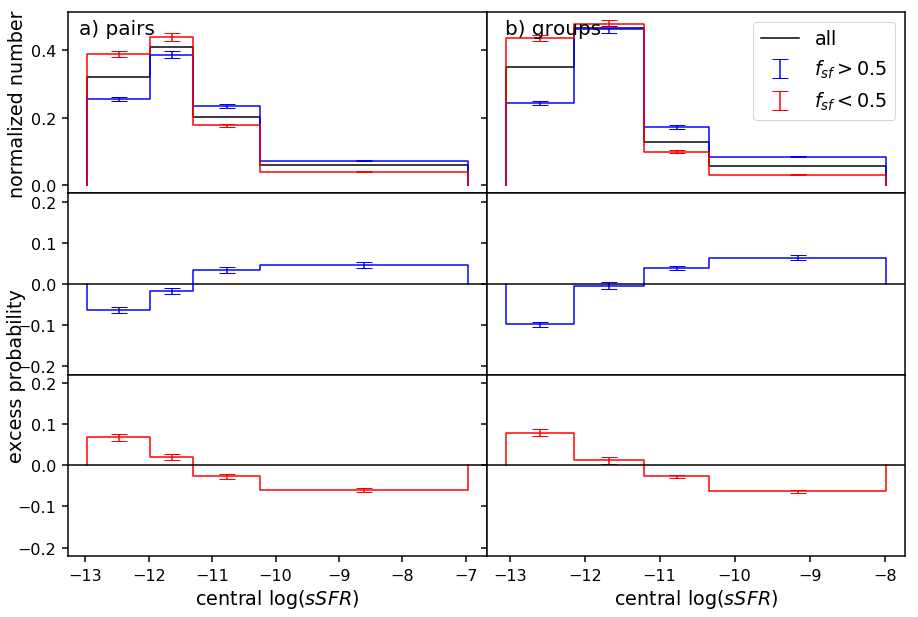

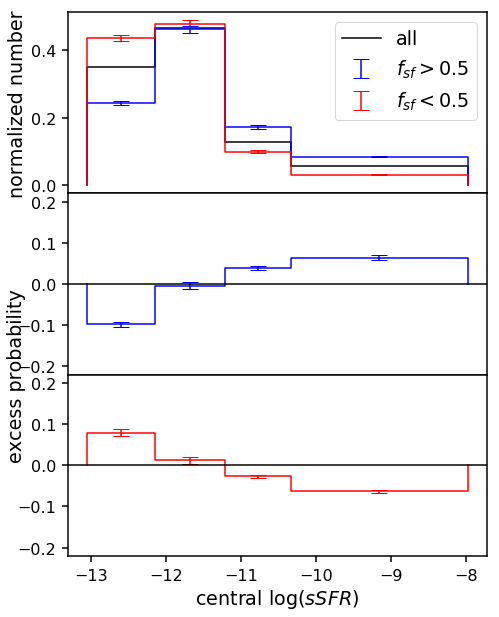

In [93]:
plt.style.use(mpl_style.style1)
high_sf_pair_ind = reduce(np.intersect1d, (halo_mass_val_ind, pair_ind, high_sat_sf_ind))
low_sf_pair_ind = reduce(np.intersect1d, (halo_mass_val_ind, pair_ind, low_sat_sf_ind))

high_sf_group_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, high_sat_sf_ind))
low_sf_group_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, low_sat_sf_ind))

low_sf_pair_cent_ssfr = group_table['cent_ssfr'][low_sf_pair_ind]
high_sf_pair_cent_ssfr = group_table['cent_ssfr'][high_sf_pair_ind]

low_sf_group_cent_ssfr = group_table['cent_ssfr'][low_sf_group_ind]
high_sf_group_cent_ssfr = group_table['cent_ssfr'][high_sf_group_ind]

L_arrs = [high_sf_pair_cent_ssfr, low_sf_pair_cent_ssfr]
R_arrs = [high_sf_group_cent_ssfr, low_sf_group_cent_ssfr]

#getting L and R arrays for mass

high_sf_pair_cent_mass = group_table['halo_mass_lum'][high_sf_pair_ind]
low_sf_pair_cent_mass = group_table['halo_mass_lum'][low_sf_pair_ind]

high_sf_group_cent_mass = group_table['halo_mass_lum'][high_sf_group_ind]
low_sf_group_cent_mass = group_table['halo_mass_lum'][low_sf_group_ind]

all_mass_arr = group_table['halo_mass_lum'][halo_mass_val_ind]

L_mass_arrs = [high_sf_pair_cent_mass, low_sf_pair_cent_mass]
R_mass_arrs = [high_sf_group_cent_mass, low_sf_group_cent_mass]

f1 = plot_dist(L_arrs, R_arrs,-11.3,-11.2, L_mass_arrs, R_mass_arrs, all_mass_arr, 'central '+r'$\log(sSFR)$', 'pairs', 'groups', [r'$f_{sf} > 0.5$', r'$f_{sf} < 0.5$'], bin_type='good')

plt.savefig('../plots/conformity_SF_pairsgroups', dpi=400)

plt.style.use(mpl_style.style1)
#plt.savefig('plots/mass_hist_pairsgroups', dpi=400)

f2 = plot_dist_single(R_arrs, -11.2, R_mass_arrs, all_mass_arr, 'central '+r'$\log(sSFR)$', [r'$f_{sf} > 0.5$', r'$f_{sf} < 0.5$'], bin_type='good')

plt.show()

(216, 209)
(193, 755)


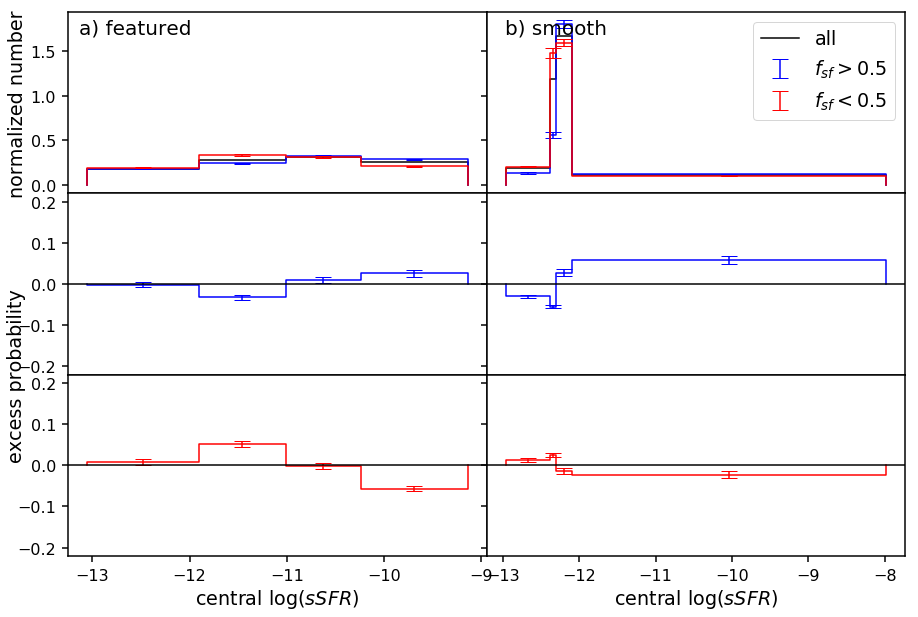

In [94]:
high_sf_spiral_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, spiral_cent_ind, high_sat_sf_ind))
low_sf_spiral_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, spiral_cent_ind, low_sat_sf_ind))

high_sf_smooth_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, smooth_cent_ind, high_sat_sf_ind))
low_sf_smooth_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, smooth_cent_ind, low_sat_sf_ind))

low_sf_spiral_cent_ssfr = group_table['cent_ssfr'][low_sf_spiral_ind]
high_sf_spiral_cent_ssfr = group_table['cent_ssfr'][high_sf_spiral_ind]

low_sf_smooth_cent_ssfr = group_table['cent_ssfr'][low_sf_smooth_ind]
high_sf_smooth_cent_ssfr = group_table['cent_ssfr'][high_sf_smooth_ind]

L_arrs = [high_sf_spiral_cent_ssfr, low_sf_spiral_cent_ssfr]
R_arrs = [high_sf_smooth_cent_ssfr, low_sf_smooth_cent_ssfr]

#for mass arrays
low_sf_spiral_mass = group_table['halo_mass_lum'][low_sf_spiral_ind]
high_sf_spiral_mass = group_table['halo_mass_lum'][high_sf_spiral_ind]

low_sf_smooth_mass = group_table['halo_mass_lum'][low_sf_smooth_ind]
high_sf_smooth_mass = group_table['halo_mass_lum'][high_sf_smooth_ind]

all_mass_arr = group_table['halo_mass_lum'][halo_mass_val_ind]

L_mass_arrs = [high_sf_spiral_mass, low_sf_spiral_mass]
R_mass_arrs = [high_sf_smooth_mass, low_sf_smooth_mass]

print(len(L_arrs[0]), len(L_arrs[1]))
print(len(R_arrs[0]), len(R_arrs[1]))

plot_dist(L_arrs, R_arrs,-11,-12.3, L_mass_arrs, R_mass_arrs, all_mass_arr, 'central '+r'$\log(sSFR)$', 'featured', 'smooth', [r'$f_{sf} > 0.5$', r'$f_{sf} < 0.5$'], bin_type='good')
plt.savefig('../plots/conformity_SF_centmorph', dpi=400)

plt.show()

/homes/jotter/.local/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


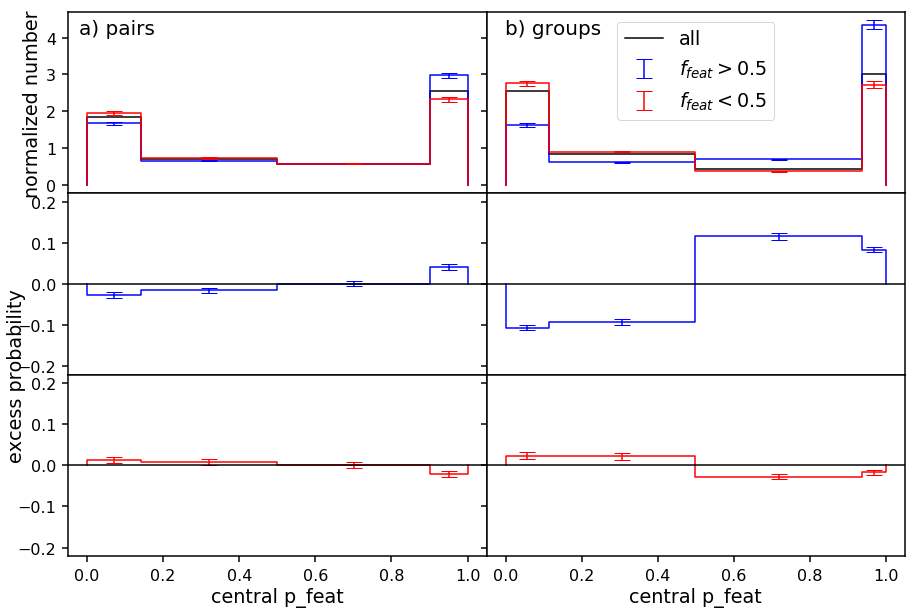

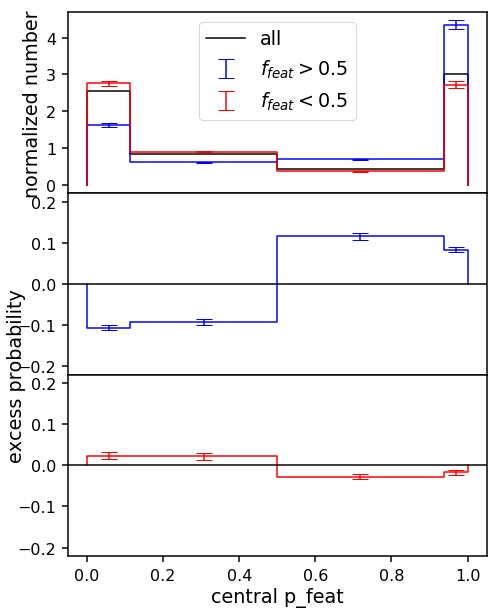

In [95]:
spiral_half_pair_ind = reduce(np.intersect1d, (halo_mass_val_ind, pair_ind, spiral_half_sat_ind))
smooth_half_pair_ind = reduce(np.intersect1d, (halo_mass_val_ind, pair_ind, smooth_half_sat_ind))

spiral_half_group_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, spiral_half_sat_ind))
smooth_half_group_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, smooth_half_sat_ind))

smooth_half_pair_cent_pfeat = group_table['cent_pfeat'][smooth_half_pair_ind]
spiral_half_pair_cent_pfeat = group_table['cent_pfeat'][spiral_half_pair_ind]

smooth_half_group_cent_pfeat = group_table['cent_pfeat'][smooth_half_group_ind]
spiral_half_group_cent_pfeat = group_table['cent_pfeat'][spiral_half_group_ind]

L_arrs = [spiral_half_pair_cent_pfeat, smooth_half_pair_cent_pfeat]
R_arrs = [spiral_half_group_cent_pfeat, smooth_half_group_cent_pfeat]

#getting L and R arrays for mass

spiral_half_pair_mass = group_table['halo_mass_lum'][spiral_half_pair_ind]
smooth_half_pair_mass = group_table['halo_mass_lum'][smooth_half_pair_ind]

spiral_half_group_mass = group_table['halo_mass_lum'][spiral_half_group_ind]
smooth_half_group_mass = group_table['halo_mass_lum'][smooth_half_group_ind]

all_mass_arr = group_table['halo_mass_lum'][halo_mass_val_ind]

L_mass_arrs = [spiral_half_pair_mass, smooth_half_pair_mass]
R_mass_arrs = [spiral_half_group_mass, smooth_half_group_mass]


f2 = plot_dist(L_arrs, R_arrs,0.5,0.5,L_mass_arrs,R_mass_arrs,all_mass_arr,'central p_feat', 'pairs', 'groups', [r'$f_{feat} > 0.5$', r'$f_{feat} < 0.5$'], bin_type='good', axloc='upper center')
plt.savefig('../plots/conformity_morph_pairsgroups', dpi=400)

f3 = plot_dist_single(R_arrs, 0.5, R_mass_arrs, all_mass_arr, 'central p_feat', [r'$f_{feat} > 0.5$', r'$f_{feat} < 0.5$'])

plt.style.use(mpl_style.style1)
plt.show()

/homes/jotter/.local/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


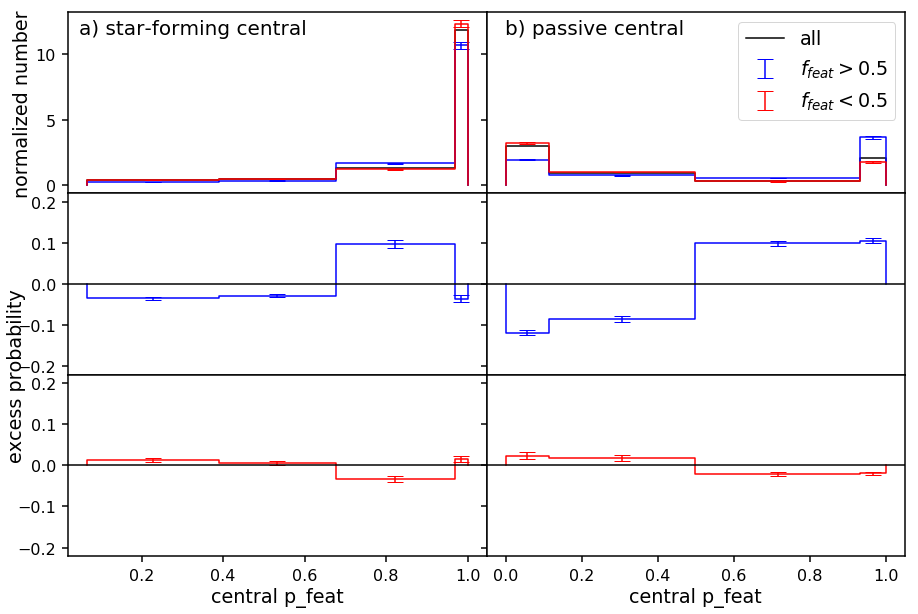

In [96]:
plt.style.use(mpl_style.style1)

spiral_half_sf_cent_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, sf_cent_ind, spiral_half_sat_ind))
smooth_half_sf_cent_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, sf_cent_ind, smooth_half_sat_ind))

spiral_half_passive_cent_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, passive_cent_ind, spiral_half_sat_ind))
smooth_half_passive_cent_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, passive_cent_ind, smooth_half_sat_ind))

smooth_half_sf_cent_cent_pfeat = group_table['cent_pfeat'][smooth_half_sf_cent_ind]
spiral_half_sf_cent_cent_pfeat = group_table['cent_pfeat'][spiral_half_sf_cent_ind]

smooth_half_passive_cent_pfeat = group_table['cent_pfeat'][smooth_half_passive_cent_ind]
spiral_half_passive_cent_pfeat = group_table['cent_pfeat'][spiral_half_passive_cent_ind]

L_arrs = [spiral_half_sf_cent_cent_pfeat, smooth_half_sf_cent_cent_pfeat]
R_arrs = [spiral_half_passive_cent_pfeat, smooth_half_passive_cent_pfeat]

#getting L and R arrays for mass

spiral_half_sf_cent_mass = group_table['halo_mass_lum'][spiral_half_sf_cent_ind]
smooth_half_sf_cent_mass = group_table['halo_mass_lum'][smooth_half_sf_cent_ind]

spiral_half_passive_cent_mass = group_table['halo_mass_lum'][spiral_half_passive_cent_ind]
smooth_half_passive_cent_mass = group_table['halo_mass_lum'][smooth_half_passive_cent_ind]

all_mass_arr = group_table['halo_mass_lum'][halo_mass_val_ind]

L_mass_arrs = [spiral_half_sf_cent_mass, smooth_half_sf_cent_mass]
R_mass_arrs = [spiral_half_passive_cent_mass, smooth_half_passive_cent_mass]

plot_dist(L_arrs, R_arrs,0.7,0.5,L_mass_arrs,R_mass_arrs,all_mass_arr,'central p_feat', 'star-forming central', 'passive central', [r'$f_{feat} > 0.5$', r'$f_{feat} < 0.5$'], bin_type='good')
plt.savefig('../plots/conformity_morph_centSF.png', dpi=400)
plt.show()

/homes/jotter/.local/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


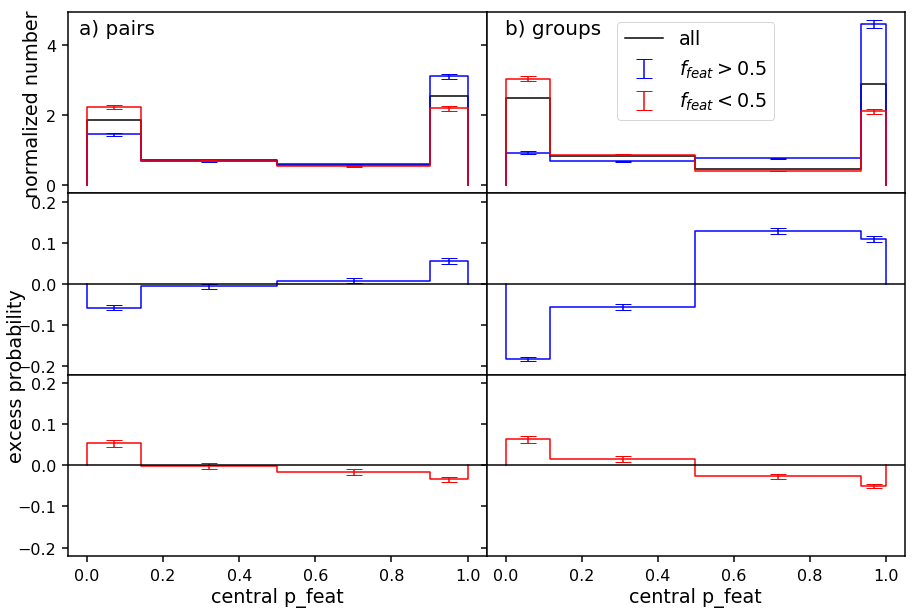

In [97]:
spiral_pair_ind = reduce(np.intersect1d, (halo_mass_val_ind, pair_ind, spiral_sat_ind))
smooth_pair_ind = reduce(np.intersect1d, (halo_mass_val_ind, pair_ind, smooth_sat_ind))
int_pair_ind = reduce(np.intersect1d, (halo_mass_val_ind, pair_ind, int_sat_ind))

spiral_group_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, spiral_sat_ind))
smooth_group_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, smooth_sat_ind))
int_group_ind = reduce(np.intersect1d, (halo_mass_val_ind, group_ind, int_sat_ind))

smooth_pair_cent_pfeat = group_table['cent_pfeat'][smooth_pair_ind]
spiral_pair_cent_pfeat = group_table['cent_pfeat'][spiral_pair_ind]
int_pair_cent_pfeat = group_table['cent_pfeat'][int_pair_ind]

smooth_group_cent_pfeat = group_table['cent_pfeat'][smooth_group_ind]
spiral_group_cent_pfeat = group_table['cent_pfeat'][spiral_group_ind]
int_group_cent_pfeat = group_table['cent_pfeat'][int_group_ind]

L_arrs = [spiral_pair_cent_pfeat, smooth_pair_cent_pfeat, int_pair_cent_pfeat]
R_arrs = [spiral_group_cent_pfeat, smooth_group_cent_pfeat, int_group_cent_pfeat]

#getting L and R arrays for mass

spiral_pair_mass = group_table['halo_mass_lum'][spiral_pair_ind]
smooth_pair_mass = group_table['halo_mass_lum'][smooth_pair_ind]
int_pair_mass = group_table['halo_mass_lum'][int_pair_ind]

spiral_group_mass = group_table['halo_mass_lum'][spiral_group_ind]
smooth_group_mass = group_table['halo_mass_lum'][smooth_group_ind]
int_group_mass = group_table['halo_mass_lum'][int_group_ind]

all_mass_arr = group_table['halo_mass_lum'][halo_mass_val_ind]

L_mass_arrs = [spiral_pair_mass, smooth_pair_mass, int_pair_mass]
R_mass_arrs = [spiral_group_mass, smooth_group_mass, int_group_mass]


f2 = plot_dist(L_arrs, R_arrs,0.5,0.5,L_mass_arrs,R_mass_arrs,all_mass_arr,'central p_feat', 'pairs', 'groups', [r'$f_{feat} > 0.5$', r'$f_{feat} < 0.5$'])
#plt.savefig('plots/conformity_morph_pairsgroups', dpi=400)

plt.style.use(mpl_style.style1)
plt.show()

(16, 50, 222)


/homes/jotter/.local/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


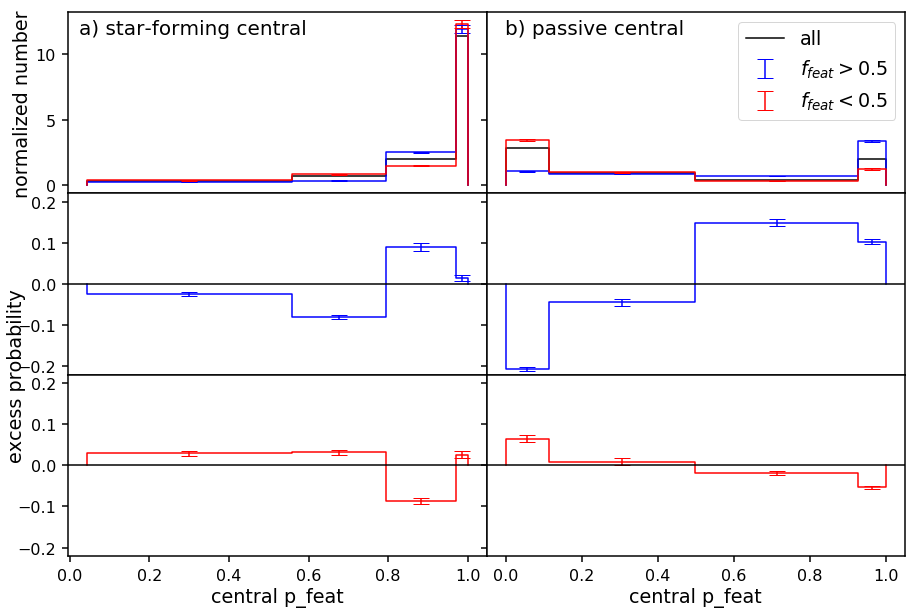

In [98]:
plt.style.use(mpl_style.style1)

spiral_sf_cent_ind = reduce(np.intersect1d, (halo_mass_val_ind, sf_cent_ind, group_ind, spiral_sat_ind))
smooth_sf_cent_ind = reduce(np.intersect1d, (halo_mass_val_ind, sf_cent_ind, group_ind, smooth_sat_ind))
int_sf_cent_ind = reduce(np.intersect1d, (halo_mass_val_ind, sf_cent_ind, group_ind, int_sat_ind))

spiral_passive_cent_ind = reduce(np.intersect1d, (halo_mass_val_ind, passive_cent_ind, group_ind, spiral_sat_ind))
smooth_passive_cent_ind = reduce(np.intersect1d, (halo_mass_val_ind, passive_cent_ind, group_ind, smooth_sat_ind))
int_passive_cent_ind = reduce(np.intersect1d, (halo_mass_val_ind, passive_cent_ind, group_ind, int_sat_ind))

smooth_sf_cent_cent_pfeat = group_table['cent_pfeat'][smooth_sf_cent_ind]
spiral_sf_cent_cent_pfeat = group_table['cent_pfeat'][spiral_sf_cent_ind]
int_sf_cent_cent_pfeat = group_table['cent_pfeat'][int_sf_cent_ind]

smooth_passive_cent_pfeat = group_table['cent_pfeat'][smooth_passive_cent_ind]
spiral_passive_cent_pfeat = group_table['cent_pfeat'][spiral_passive_cent_ind]
int_passive_cent_pfeat = group_table['cent_pfeat'][int_passive_cent_ind]

L_arrs = [spiral_sf_cent_cent_pfeat, smooth_sf_cent_cent_pfeat, int_sf_cent_cent_pfeat]
R_arrs = [spiral_passive_cent_pfeat, smooth_passive_cent_pfeat, int_passive_cent_pfeat]

#getting L and R arrays for mass

spiral_sf_cent_mass = group_table['halo_mass_lum'][spiral_sf_cent_ind]
smooth_sf_cent_mass = group_table['halo_mass_lum'][smooth_sf_cent_ind]
int_sf_cent_mass = group_table['halo_mass_lum'][int_sf_cent_ind]

spiral_passive_cent_mass = group_table['halo_mass_lum'][spiral_passive_cent_ind]
smooth_passive_cent_mass = group_table['halo_mass_lum'][smooth_passive_cent_ind]
int_passive_cent_mass = group_table['halo_mass_lum'][int_passive_cent_ind]

all_mass_arr = group_table['halo_mass_lum'][halo_mass_val_ind]

L_mass_arrs = [spiral_sf_cent_mass, smooth_sf_cent_mass, int_sf_cent_mass]
R_mass_arrs = [spiral_passive_cent_mass, smooth_passive_cent_mass, int_passive_cent_mass]
print(len(L_arrs[0]), len(L_arrs[1]), len(L_arrs[2]))
plot_dist(L_arrs, R_arrs,0.8,0.5,L_mass_arrs,R_mass_arrs,all_mass_arr,'central p_feat', 'star-forming central', 'passive central', [r'$f_{feat} > 0.5$', r'$f_{feat} < 0.5$'])
plt.show()

In [78]:
bluact_ind = np.intersect1d(np.where(galaxy_table['redorblue'] == 'blue')[0], np.where(galaxy_table['passiveorSFing'] == 'SFing')[0])
len(bluact_ind)

3034

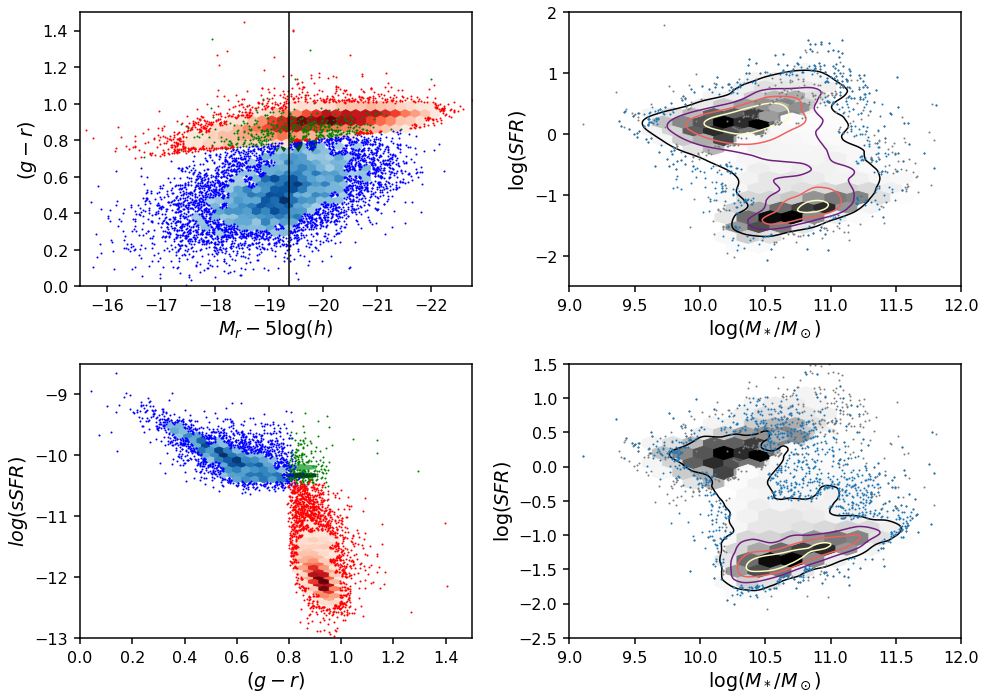

In [79]:
fig = plt.figure(figsize=(14,10))

#Magnitude limit calculation
z_lim = 0.06
d = cosmo.luminosity_distance(z_lim).to(u.pc)
m = 17 #min brightness we can observe
M_limit = m - 5*math.log(d.value,10) + 5 #absolute magnitude of min brightness we can observe
adj_M_limit = M_limit - 5*math.log(h,10)

galaxy_table_uncut = Table(fits.getdata('galaxy_table_update_nocut.fits'))

bluact_uncut_ind = np.intersect1d(np.where(galaxy_table_uncut['redorblue'] == 'blue')[0], np.where(galaxy_table_uncut['passiveorSFing'] == 'SFing')[0])
redact_uncut_ind = np.intersect1d(np.where(galaxy_table_uncut['redorblue'] == 'red')[0], np.where(galaxy_table_uncut['passiveorSFing'] == 'SFing')[0])
redpas_uncut_ind = np.intersect1d(np.where(galaxy_table_uncut['redorblue'] == 'red')[0], np.where(galaxy_table_uncut['passiveorSFing'] == 'passive')[0])

colors_uncut = [galaxy_table_uncut['color'][bluact_uncut_ind], galaxy_table_uncut['color'][redact_uncut_ind], galaxy_table_uncut['color'][redpas_uncut_ind]] #this method gets the first element of the tuples
mrs_uncut = [galaxy_table_uncut['M_r-5logh'][bluact_uncut_ind], galaxy_table_uncut['M_r-5logh'][redact_uncut_ind], galaxy_table_uncut['M_r-5logh'][redpas_uncut_ind]]

bluact_ind = np.intersect1d(np.where(galaxy_table['redorblue'] == 'blue')[0], np.where(galaxy_table['passiveorSFing'] == 'SFing')[0])
redact_ind = np.intersect1d(np.where(galaxy_table['redorblue'] == 'red')[0], np.where(galaxy_table['passiveorSFing'] == 'SFing')[0])
redpas_ind = np.intersect1d(np.where(galaxy_table['redorblue'] == 'red')[0], np.where(galaxy_table['passiveorSFing'] == 'passive')[0])

colors = [galaxy_table['color'][bluact_ind], galaxy_table['color'][redact_ind], galaxy_table['color'][redpas_ind]] #this method gets the first element of the tuples
mrs = [galaxy_table['M_r-5logh'][bluact_ind], galaxy_table['M_r-5logh'][redact_ind], galaxy_table['M_r-5logh'][redpas_ind]]
ssfrs = [galaxy_table['ssfr'][bluact_ind], galaxy_table['ssfr'][redact_ind], galaxy_table['ssfr'][redpas_ind]]
masses = [galaxy_table['mstell'][bluact_ind], galaxy_table['mstell'][redact_ind], galaxy_table['mstell'][redpas_ind]]

spiral_ind = np.where(galaxy_table['pfeatures'] >= 0.5)[0]
smooth_ind = np.where(galaxy_table['pfeatures'] < 0.5)[0]

spiral_mass = galaxy_table['mstell'][spiral_ind]
smooth_mass = galaxy_table['mstell'][smooth_ind]
spiral_sfr = spiral_mass+galaxy_table['ssfr'][spiral_ind]
smooth_sfr = smooth_mass+galaxy_table['ssfr'][smooth_ind]

nonzero_spiral_ind = np.where(spiral_mass > 0)
nonzero_spiral_mass = spiral_mass[nonzero_spiral_ind]
nonzero_spiral_sfr = spiral_sfr[nonzero_spiral_ind]
nonzero_smooth_ind = np.where(smooth_mass > 0)
nonzero_smooth_mass = smooth_mass[nonzero_smooth_ind]
nonzero_smooth_sfr = smooth_sfr[nonzero_smooth_ind]

plot_color = ['b', 'g', 'r']
colormaps = ['Blues', 'Greens', 'Reds']

plt.style.use(mpl_style.style1)
#top left plot
ax1 = fig.add_subplot(221)
for i in np.arange(3):
    hs.hex_scatter(mrs_uncut[i], colors_uncut[i], min_cnt=20,
                  hkwargs={'cmap':colormaps[i],'gridsize':40},
                  skwargs={'color':plot_color[i]}
                  )
    #ax1.scatter(mrs_uncut[i], colors_uncut[i], color = plot_color[i], s=0.1, alpha=0.5)
plt.axvline(adj_M_limit,c='k')
ax1.set_ylabel(r'$(g-r)$')
ax1.set_xlabel(r'$M_r - 5\log(h)$')
ax1.set_ylim(0, 1.5)
ax1.set_xlim(-15.5, -22.75)

#top right plot
ax2 = fig.add_subplot(222)
for i in np.arange(3):
    hs.hex_scatter(masses[i], np.array(masses[i])+np.array(ssfrs[i]), min_cnt=10,
        hkwargs={'cmap':'Greys','gridsize':80},
        skwargs={'color':'grey'}
        )
    #ax2.scatter(masses[i], np.array(masses[i])+np.array(ssfrs[i]), color = 'gray', s=0.1, alpha=0.5)
#ax2.scatter(spiral_mass, spiral_sfr, color='blue')
hs.hex_contour(nonzero_spiral_mass, nonzero_spiral_sfr, min_cnt = 20, levels=4,hkwargs={'gridsize':20}) #'extent':[9,12,3,-2.5],
ax2.set_xlabel(r'$\log(M_*/M_\odot)$') 
ax2.set_ylabel(r'$\log(SFR)$')
ax2.set_ylim(-2.5, 2)
#ax2.set_xscale('log')
ax2.set_xlim(9, 12)

#bottom left plot
ax3 = fig.add_subplot(223)
for i in np.arange(3):
    #ax3.scatter(colors[i], ssfrs[i], color = plot_color[i], s=0.1, alpha=0.5)
    hs.hex_scatter(colors[i], ssfrs[i], min_cnt=20,
                  hkwargs={'cmap':colormaps[i],'gridsize':40},
                  skwargs={'color':plot_color[i]}
                  )
ax3.set_ylabel(r'$log(sSFR)$')
ax3.set_xlabel(r'$(g-r)$')
ax3.set_ylim(-13, -8.5)
ax3.set_xlim(0,1.5)

#bottom right plot
ax4 = fig.add_subplot(224)
for i in np.arange(3):
    hs.hex_scatter(masses[i], np.array(masses[i])+np.array(ssfrs[i]), min_cnt=10,
                  hkwargs={'cmap':'Greys','gridsize':80},
                  skwargs={'color':'grey'}
                  )
    #ax4.scatter(masses[i], np.array(masses[i])+np.array(ssfrs[i]), color = 'gray', s=0.1, alpha=0.5)
#ax4.scatter(smooth_mass, smooth_sfr, color='red')
hs.hex_contour(smooth_mass, smooth_sfr, levels = 4, min_cnt = 20)
ax4.set_xlabel(r'$\log(M_*/M_\odot)$')
ax4.set_ylabel(r'$\log(SFR)$')
ax4.set_ylim(-2.5, 1.5)
#ax4.set_xscale('log')
ax4.set_xlim(9, 12)

plt.tight_layout()
plt.savefig('../plots/sample_plot_hex.png', dpi=300)
plt.show()

/homes/jotter/.local/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/homes/jotter/.local/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


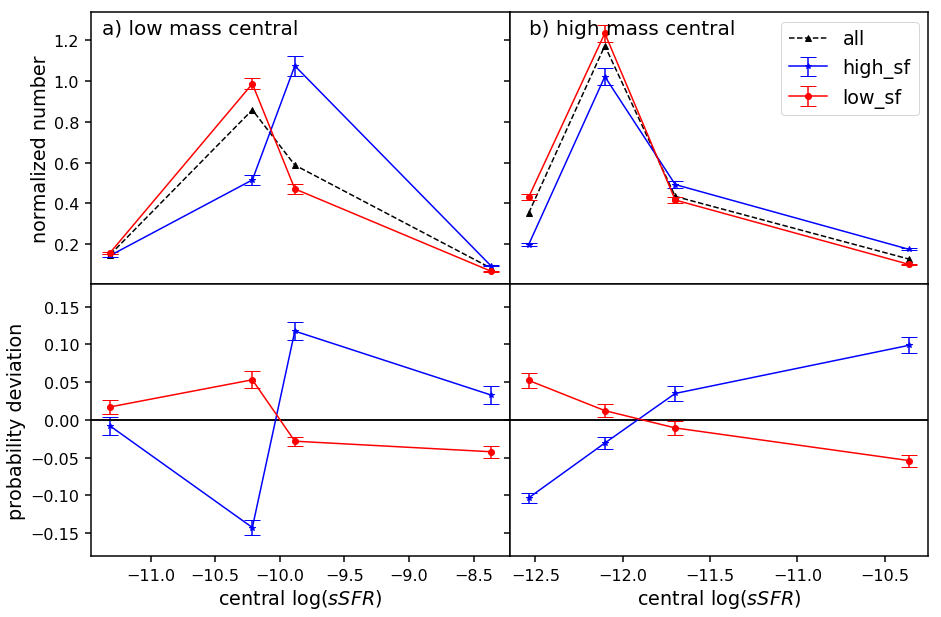

In [45]:
high_sf_low_mass_cent_ind = reduce(np.intersect1d, (cent_mass_val_ind, low_mass_cent_ind, high_sat_sf_ind))
low_sf_low_mass_cent_ind = reduce(np.intersect1d, (cent_mass_val_ind, low_mass_cent_ind, low_sat_sf_ind))

high_sf_high_mass_cent_ind = reduce(np.intersect1d, (cent_mass_val_ind, high_mass_cent_ind, high_sat_sf_ind))
low_sf_high_mass_cent_ind = reduce(np.intersect1d, (cent_mass_val_ind, high_mass_cent_ind, low_sat_sf_ind))

low_sf_low_mass_cent_ssfr = group_table['cent_ssfr'][low_sf_low_mass_cent_ind]
high_sf_low_mass_cent_ssfr = group_table['cent_ssfr'][high_sf_low_mass_cent_ind]

low_sf_high_mass_cent_ssfr = group_table['cent_ssfr'][low_sf_high_mass_cent_ind]
high_sf_high_mass_cent_ssfr = group_table['cent_ssfr'][high_sf_high_mass_cent_ind]

L_arrs = [high_sf_low_mass_cent_ssfr, low_sf_low_mass_cent_ssfr]
R_arrs = [high_sf_high_mass_cent_ssfr, low_sf_high_mass_cent_ssfr]

#for mass arrays
high_sf_low_mass_cent_mass_ind = reduce(np.intersect1d, (cent_ind, mass_val_ind_gal, low_mass_cent_ind_gal, SFingsat_ind_gal))
low_sf_low_mass_cent_mass_ind = reduce(np.intersect1d, (cent_ind, mass_val_ind_gal, low_mass_cent_ind_gal, passivesat_ind_gal))

high_sf_high_mass_cent_mass_ind = reduce(np.intersect1d, (cent_ind, mass_val_ind_gal, high_mass_cent_ind_gal, SFingsat_ind_gal))
low_sf_high_mass_cent_mass_ind = reduce(np.intersect1d, (cent_ind, mass_val_ind_gal, high_mass_cent_ind_gal, passivesat_ind_gal))

high_sf_low_mass_cent_mass = galaxy_table['halo_mass_lum'][high_sf_low_mass_cent_mass_ind]
low_sf_low_mass_cent_mass = galaxy_table['halo_mass_lum'][low_sf_low_mass_cent_mass_ind]

high_sf_high_mass_cent_mass = galaxy_table['halo_mass_lum'][high_sf_high_mass_cent_mass_ind]
low_sf_high_mass_cent_mass = galaxy_table['halo_mass_lum'][low_sf_high_mass_cent_mass_ind]

all_cent_mass_ind = reduce(np.intersect1d, (cent_ind, mass_val_ind_gal))
all_mass_arr = galaxy_table['halo_mass_lum'][all_cent_mass_ind]

L_mass_arrs = [high_sf_low_mass_cent_mass, low_sf_low_mass_cent_mass]
R_mass_arrs = [high_sf_high_mass_cent_mass, low_sf_high_mass_cent_mass]

plot_dist(L_arrs, R_arrs,-10,-12,L_mass_arrs,R_mass_arrs,all_mass_arr,'central '+r'$\log(sSFR)$', 'low mass central', 'high mass central', ['high_sf', 'low_sf'], axloc='upper right')
plt.savefig('plots/conformity_SF_centmass', dpi=400)

high_mass_cent_mass_ind = np.intersect1d(high_mass_cent_ind_gal, mass_val_ind_gal)
low_mass_cent_mass_ind = np.intersect1d(low_mass_cent_ind_gal, mass_val_ind_gal)

#mass_histogram([galaxy_table['mass'][high_mass_cent_mass_ind], galaxy_table['mass'][low_mass_cent_mass_ind]], ['high mass central', 'low mass central'])

plt.style.use(mpl_style.style1)
#plt.savefig('plots/mass_hist_centmass', dpi=400)
plt.show()

Text(0,0.5,'central mass $\\log(M/M_\\odot)$')

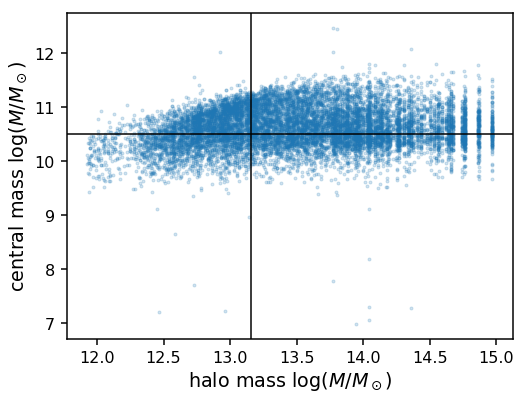

In [60]:
#halo mass/central mass scatterplot
ind = np.intersect1d(halo_mass_val_ind_gal, mass_val_ind_gal)
plt.scatter(galaxy_table['halo_mass'][ind], galaxy_table['mass'][ind], marker='.', alpha=0.2)
plt.axvline(13 - np.log10(h), c='k')
plt.axhline(10.5, c='k')
plt.xlabel('halo mass'+r' $\log(M/M_\odot)$')
plt.ylabel('central mass'+r' $\log(M/M_\odot)$')

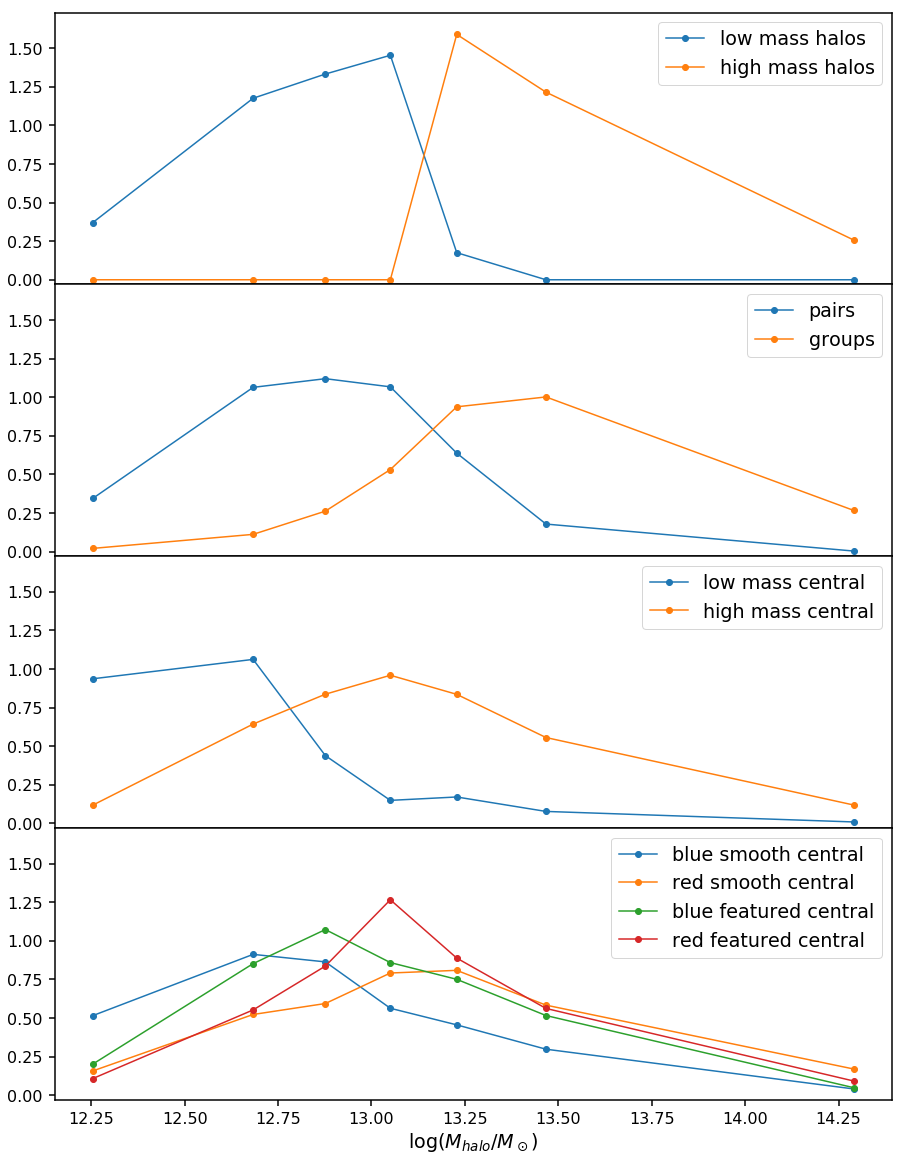

In [158]:
#create halo mass histograms with different central properties

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, figsize=(15,20))

ax = [ax1, ax2, ax3, ax4]

plot1inds = [low_mass_halo_ind, high_mass_halo_ind]
plot2inds = [pair_ind, group_ind]
plot3inds = [low_mass_cent_ind, high_mass_cent_ind]
plot4inds = [blueelliptical_cent_ind, redelliptical_cent_ind, bluespiral_cent_ind, redspiral_cent_ind]

plot1labs = ['low mass halos', 'high mass halos']
plot2labs = ['pairs', 'groups']
plot3labs = ['low mass central', 'high mass central']
plot4labs = ['blue smooth central', 'red smooth central', 'blue featured central', 'red featured central']

plotinds = [plot1inds, plot2inds, plot3inds, plot4inds]
plotlabs = [plot1labs, plot2labs, plot3labs, plot4labs]

total_arr = group_table['halo_mass'][halo_mass_val_ind]
bin_edges = np.percentile(total_arr, np.linspace(0,100,8)) #percentile bins
#bin_edges = np.linspace(np.min(total_arr), np.max(total_arr), 8) #linear bins

plotpts = []
for b in range(len(bin_edges[:-1])): #creating points to plot - midpoints of bins
    plotpts.append(bin_edges[b] + (bin_edges[b+1]-bin_edges[b])/2)

for i in range(len(plotinds)):
    for j in range(len(plotinds[i])):
        ind = np.intersect1d(plotinds[i][j],halo_mass_val_ind)
        arr = group_table['halo_mass'][ind]
        hist, bins = np.histogram(arr, density=True, bins = bin_edges)
        
        ax[i].plot(plotpts, hist, marker='o', label=plotlabs[i][j])
    ax[i].legend(loc='upper right')
    ax[i].set_ylim(-.03,1.73)
ax[-1].set_xlabel(r'$\log(M_{halo}/M_\odot)$')

f.subplots_adjust(hspace=0)
plt.style.use(mpl_style.style1)
#plt.savefig('plots/halo_mass_hist_groups_linbins', dpi=400)
#plt.savefig('plots/halo_mass_hist_groups_percbins', dpi=400)
plt.show()

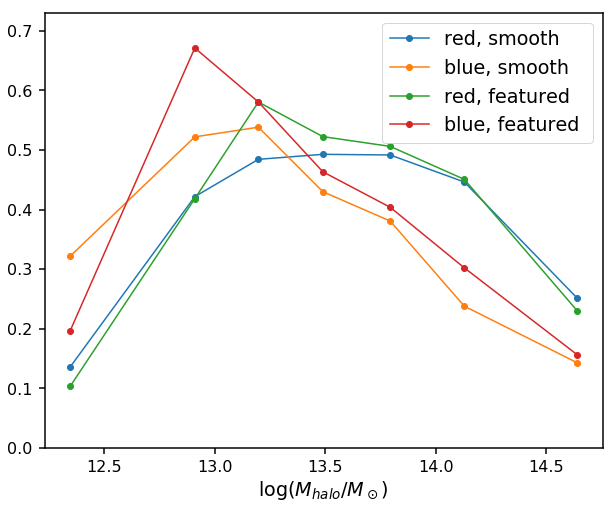

In [159]:
#create halo mass histograms for different galaxy types - not central properties

f = plt.figure(figsize=(10,8))
ax = plt.axes()

plotinds = [redelliptical_ind_gal, blueelliptical_ind_gal, redspiral_ind_gal, bluespiral_ind_gal]

plotlabs = ['red, smooth', 'blue, smooth', 'red, featured', 'blue, featured ']

total_arr = galaxy_table['halo_mass'][halo_mass_val_ind_gal]
bin_edges = np.percentile(total_arr, np.linspace(0,100,8))

plotpts = []
for b in range(len(bin_edges[:-1])): #creating points to plot - midpoints of bins
    plotpts.append(bin_edges[b] + (bin_edges[b+1]-bin_edges[b])/2)

for i in range(len(plotinds)):
    ind = np.intersect1d(plotinds[i],halo_mass_val_ind_gal)
    arr = galaxy_table['halo_mass'][ind]
    hist, bins = np.histogram(arr, density=True, bins = bin_edges)
    ax.plot(plotpts, hist, marker='o', label=plotlabs[i])
    
ax.legend(loc='upper right')
ax.set_ylim(0,.73)
ax.set_xlabel(r'$\log(M_{halo}/M_\odot)$')

plt.style.use(mpl_style.style1)
plt.savefig('plots/morph_color_halomass', dpi=400)
plt.show()

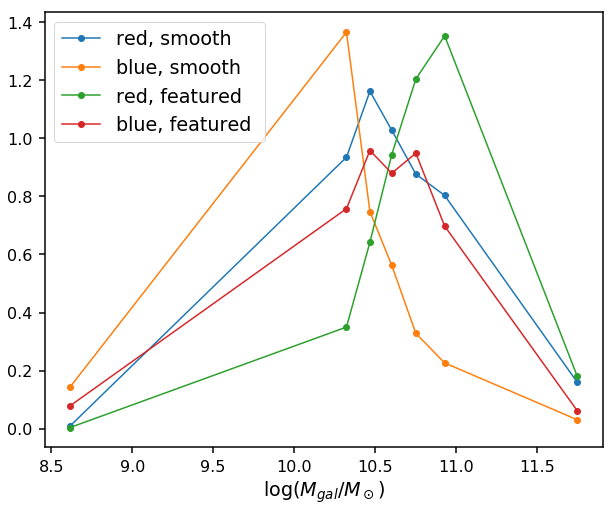

In [160]:
#create galaxy mass histograms for different galaxy types - not central properties

f = plt.figure(figsize=(10,8))
ax = plt.axes()

plotinds = [redelliptical_ind_gal, blueelliptical_ind_gal, redspiral_ind_gal, bluespiral_ind_gal]

plotlabs = ['red, smooth', 'blue, smooth', 'red, featured', 'blue, featured ']

total_arr = galaxy_table['mass'][mass_val_ind_gal]
bin_edges = np.percentile(total_arr, np.linspace(0,100,8))

plotpts = []
for b in range(len(bin_edges[:-1])): #creating points to plot - midpoints of bins
    plotpts.append(bin_edges[b] + (bin_edges[b+1]-bin_edges[b])/2)

for i in range(len(plotinds)):
    ind = np.intersect1d(plotinds[i],halo_mass_val_ind_gal)
    arr = galaxy_table['mass'][ind]
    hist, bins = np.histogram(arr, density=True, bins = bin_edges)
    ax.plot(plotpts, hist, marker='o', label=plotlabs[i])
    
ax.legend(loc='upper left')
#ax.set_ylim(-.03,.92)
ax.set_xlabel(r'$\log(M_{gal}/M_\odot)$')

plt.style.use(mpl_style.style1)
#plt.savefig('plots/morph_color_galaxymass', dpi=400)
plt.show()

4282
722
639
2154


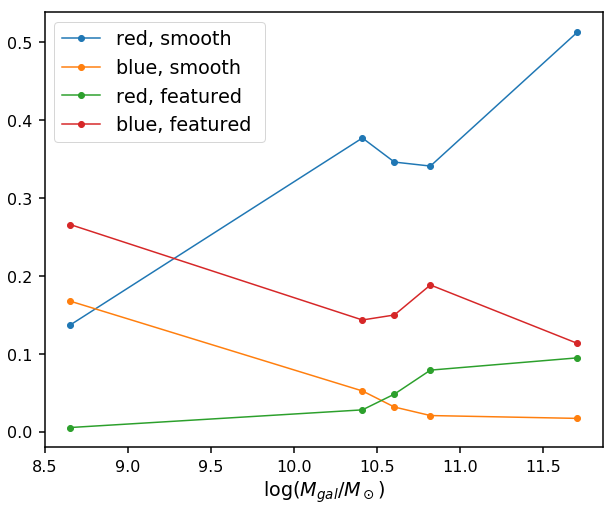

In [16]:
#fraction of galaxy type as function of galaxy mass

f = plt.figure(figsize=(10,8))
ax = plt.axes()

plotinds = [redelliptical_ind_gal, blueelliptical_ind_gal, redspiral_ind_gal, bluespiral_ind_gal]

plotlabs = ['red, smooth', 'blue, smooth', 'red, featured', 'blue, featured ']

total_arr = galaxy_table['mass'][mass_val_ind_gal]
bin_edges = np.percentile(total_arr, np.linspace(0,100,6))

plotpts = []
for b in range(len(bin_edges[:-1])): #creating points to plot - midpoints of bins
    plotpts.append(bin_edges[b] + (bin_edges[b+1]-bin_edges[b])/2)

total_hist, bins = np.histogram(total_arr, density=False, bins=bin_edges)    

for i in range(len(plotinds)):
    ind = np.intersect1d(plotinds[i],halo_mass_val_ind_gal)
    arr = galaxy_table['mass'][ind]
    hist, bins = np.histogram(arr, density=False, bins = bin_edges)
    ax.plot(plotpts, hist/total_hist, marker='o', label=plotlabs[i])
    print(len(arr))
    
ax.legend(loc='upper left')
#ax.set_ylim(-.03,.92)
ax.set_xlabel(r'$\log(M_{gal}/M_\odot)$')

plt.style.use(mpl_style.style1)
#plt.savefig('plots/morph_color_galaxymass', dpi=400)
plt.show()

/homes/jotter/.local/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/homes/jotter/.local/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


ValueError: weights should have the same shape as a.

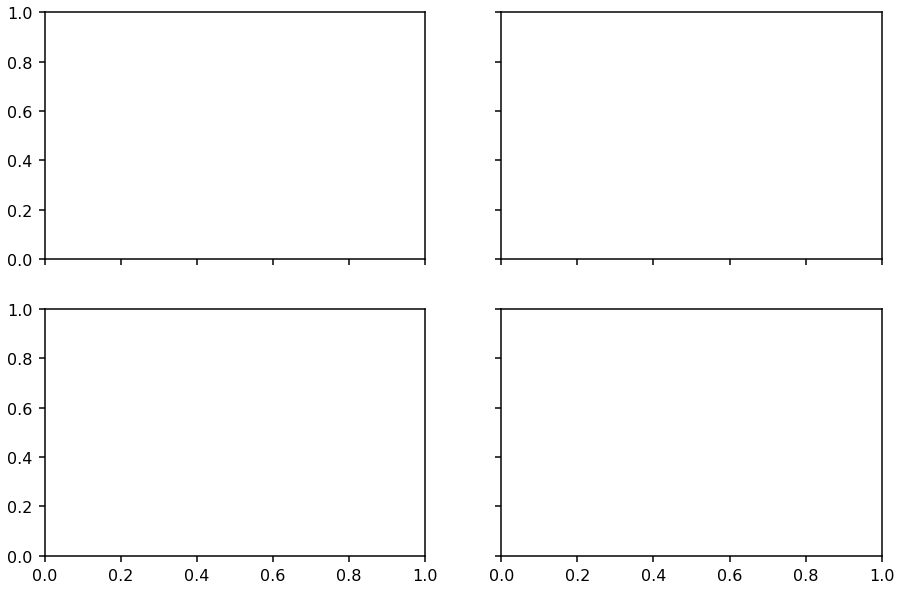

In [25]:
### NOTE THE NEW WEIGHTING WILL NOT WORK WITH HALO MASS

high_sf_low_mass_ind = reduce(np.intersect1d, (cent_mass_val_ind, low_mass_halo_ind, high_sf_ind))
low_sf_low_mass_ind = reduce(np.intersect1d, (cent_mass_val_ind, low_mass_halo_ind, low_sf_ind))

high_sf_high_mass_ind = reduce(np.intersect1d, (cent_mass_val_ind, high_mass_cent_ind, high_sf_ind))
low_sf_high_mass_ind = reduce(np.intersect1d, (cent_mass_val_ind, high_mass_cent_ind, low_sf_ind))

low_sf_low_mass_cent_ssfr = group_table['cent_ssfr'][low_sf_low_mass_ind]
high_sf_low_mass_cent_ssfr = group_table['cent_ssfr'][high_sf_low_mass_ind]

low_sf_high_mass_cent_ssfr = group_table['cent_ssfr'][low_sf_high_mass_ind]
high_sf_high_mass_cent_ssfr = group_table['cent_ssfr'][high_sf_high_mass_ind]

L_arrs = [high_sf_low_mass_cent_ssfr, low_sf_low_mass_cent_ssfr]
R_arrs = [high_sf_high_mass_cent_ssfr, low_sf_high_mass_cent_ssfr]
labels = ['high_sf', 'low_sf']

#for mass arrays
high_sf_low_mass_cent_mass_ind = reduce(np.intersect1d, (cent_ind, mass_val_ind_gal, low_mass_halo_ind_gal, SFingsat_ind_gal))
low_sf_low_mass_cent_mass_ind = reduce(np.intersect1d, (cent_ind, mass_val_ind_gal, low_mass_halo_ind_gal, passivesat_ind_gal))

high_sf_high_mass_cent_mass_ind = reduce(np.intersect1d, (cent_ind, mass_val_ind_gal, high_mass_cent_ind_gal, SFingsat_ind_gal))
low_sf_high_mass_cent_mass_ind = reduce(np.intersect1d, (cent_ind, mass_val_ind_gal, high_mass_cent_ind_gal, passivesat_ind_gal))

high_sf_low_mass_cent_mass = galaxy_table['halo_mass'][high_sf_low_mass_cent_mass_ind]
low_sf_low_mass_cent_mass = galaxy_table['halo_mass'][low_sf_low_mass_cent_mass_ind]

high_sf_high_mass_cent_mass = galaxy_table['halo_mass'][high_sf_high_mass_cent_mass_ind]
low_sf_high_mass_cent_mass = galaxy_table['halo_mass'][low_sf_high_mass_cent_mass_ind]

L_mass_arrs = [high_sf_low_mass_cent_mass, low_sf_low_mass_cent_mass]
R_mass_arrs = [high_sf_high_mass_cent_mass, low_sf_high_mass_cent_mass]

plot_dist(L_arrs, R_arrs,-12,-10.5,L_mass_arrs,R_mass_arrs,'central '+r'$\log(sSFR)$', 'low mass halo', 'high mass halo', ['high_sf', 'low_sf'])
plt.savefig('plots/conformity_SF_halomass', dpi=400)

high_mass_halo_mass_ind = np.intersect1d(high_mass_halo_ind_gal, mass_val_ind_gal)
low_mass_halo_mass_ind = np.intersect1d(low_mass_halo_ind_gal, mass_val_ind_gal)

mass_histogram([galaxy_table['mass'][low_mass_halo_mass_ind], galaxy_table['mass'][high_mass_halo_mass_ind]], ['in low mass halo', 'in high mass halo'])

plt.style.use(mpl_style.style1)
plt.savefig('plots/mass_hist_halomass', dpi=400)
plt.show()

In [6]:
def plot_dist_two(arrs, cross, mass_arrs, all_mass, xlabel, plot_labels, bin_type='good', axloc='best'):
    f, (ax1, ax2) = plt.subplots(2, sharex='col')
    axs = [ax1, ax2]
    f.set_figheight(10)
    f.set_figwidth(7)
    
    hists = []
    plotpts = []

    colors = ['b', 'r']
    markers = ['*', 'o']
    labels = ['', '']
    
    total_mass = np.concatenate(mass_arrs)
    
    #get weights for total, then can split for arrays[0] and arrays[1]
    coeff_arr, mbins = mass_match([total_mass], all_mass)

    mbins = mbins[:-1]
    
    coeffs = coeff_arr[0]
    coeffs[np.where(np.isnan(coeffs) == True)[0]] = 0

    use_label = [plot_labels[0], plot_labels[1], 'all']

    total = np.concatenate(arrs)

    whichmassbin = np.digitize(total_mass, mbins) #this gives which # mass bin each entry is in
    whichmassbin = whichmassbin - 1
    weights_all = np.array(whichmassbin, dtype='float')
    for b in range(len(mbins)):
        ind = np.where(whichmassbin == b)[0]
        weights_all[ind] = coeffs[b] #changes bin number to the actual weight coefficient

    weights1 = weights_all[:len(arrs[0])]
    weights2 = weights_all[len(arrs[0]):(len(arrs[0])+len(arrs[1]))]
    weight_arr = [weights1, weights2]

    if bin_type == 'good':
        total_lower = total[total < cross]
        total_upper = total[total >= cross]
        bin_edges_lower = np.percentile(total_lower, np.array((0,50,100)))
        bin_edges_upper = np.percentile(total_upper, np.array((50,100)))
        bin_edges = np.concatenate((bin_edges_lower, bin_edges_upper))
    if bin_type == 'linear':
        bin_edges = np.percentile(total, np.linspace(0,100,10))

    plotpts = []
    for b in range(len(bin_edges[:-1])): #creating points to plot - midpoints of bins
        plotpts.append(bin_edges[b] + (bin_edges[b+1]-bin_edges[b])/2)

    total_hist, bins = np.histogram(total, weights=weights_all, density=True, bins=bin_edges) #total histogram, bins is throwaway
    ax1.plot(plotpts, total_hist, c='k', marker='^', linestyle='--', label=use_label[2])

    for j in range(2): #looping for two arrays within one side
        bad_ind = np.concatenate((np.where(np.isnan(weight_arr[j]) == True)[0], np.where(np.isinf(weight_arr[j]) == True)[0]))
        weight_fixed = weight_arr[j]
        #weight_fixed[bad_ind] = 0

        norm_hist, bins = np.histogram(arrs[j], weights=weight_fixed, density=True, bins=bin_edges)
        unnorm_hist, bins = np.histogram(arrs[j], weights=weight_fixed, density=False, bins=bin_edges)

        unnorm_yerr = np.sqrt(unnorm_hist) #sqrt(N) errors
        norm_yerr = (unnorm_yerr/unnorm_hist)*norm_hist

        #top histogram plot
        ax1.errorbar(plotpts, norm_hist, norm_yerr, capsize=8, c=colors[j], marker = markers[j], label=use_label[j])

        #ax[0].set_ylim(-0.05, 3)
        #bottom difference plot
        dev = norm_hist - total_hist

        dev = dev*(bin_edges[1:] - bin_edges[:-1])
        dev_errs = norm_yerr*(bin_edges[1:] - bin_edges[:-1])

        ax2.errorbar(plotpts, dev, dev_errs, capsize=8, c=colors[j], marker = markers[j], label=use_label[j])
        ax2.axhline(0, c='k')
        ax2.set_xlabel(xlabel)
        ax2.set_ylim(-0.18,0.18)
        #ax[1].set_xlim(0,1)
    ax1.set_ylabel('normalized number')
    dev_label = 'probability deviation'
    ax2.set_ylabel(dev_label)
    
    ax1.legend(loc=axloc)
    
    f.subplots_adjust(wspace=0)
    f.subplots_adjust(hspace=0)

    return f